In [1]:
import sqlite3 as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db='chinook.db'
def run_query(query):
    with sq.connect(db) as conn:
        return pd.read_sql(query,conn)

In [3]:
def run_command(command):
    with sq.connect('chinook.db') as conn:
        conn.isolation_level=none
        conn.execute(command)
    

In [4]:
def show_tables(query_string):
    return run_query(query_string)
    
    

In [5]:
db_info_query="SELECT name, type FROM sqlite_master WHERE type IN (\"table\",\"view\");"




In [6]:
show_tables(db_info_query)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


We have to decide which are the top 3 selling genres in our store so we can incorporate new products in those 3 genres. Let's find out!

In [7]:
my_query='''

    SELECT
        SUM(i.unit_price) 'Total $ sold', SUM(i.quantity) 'Total units sold', g.name
    FROM
        invoice_line i
    INNER JOIN track t ON t.track_id = i.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY 1 DESC

'''
run_query(my_query)

,Total $ sold,Total units sold,name
0,2608.65,2635,Rock
1,612.81,619,Metal
2,487.08,492,Alternative & Punk
3,165.33,167,Latin
4,157.41,159,R&B/Soul
5,122.76,124,Blues
6,119.79,121,Jazz
7,115.83,117,Alternative
8,73.26,74,Easy Listening
9,62.37,63,Pop


As we can see, the top selling genres by $ ammount are Rock/Metal, Alternative/Punk and Latin.

Let's see by units sold

In [8]:
my_query='''

    SELECT
        SUM(i.unit_price) 'Total $ sold', SUM(i.quantity) 'Total units sold', g.name
    FROM
        invoice_line i
    INNER JOIN track t ON t.track_id = i.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY 2 DESC

'''
run_query(my_query)

,Total $ sold,Total units sold,name
0,2608.65,2635,Rock
1,612.81,619,Metal
2,487.08,492,Alternative & Punk
3,165.33,167,Latin
4,157.41,159,R&B/Soul
5,122.76,124,Blues
6,119.79,121,Jazz
7,115.83,117,Alternative
8,73.26,74,Easy Listening
9,62.37,63,Pop


Same results. Thus, out of the 4 new artist that we want to incorporate, we should lean to the ones in these genres.

here are the four nominees: 

Regal	Hip-Hop
Red Tone	Punk
Meteor and the Girls	Pop
Slim Jim Bites	Blues

### Out of these, and based only on our current sales, we should go with: Red Tone, Meteor and the Girls, and Slim Jim Bites!!!

Let's dig some more about these current sales and enhance our presentation of results so it's easier to interpret.

First, the label specializes on US artists, so let's limit our query to US artists only.


In [9]:
my_query='''
WITH usa_only AS(
    SELECT * 
    FROM invoice_line i 
    INNER JOIN invoice inv ON inv.invoice_id = i.invoice_id
    WHERE inv.billing_country = "USA"
)
    SELECT
        SUM(us.unit_price) 'Total $ sold', SUM(us.quantity) 'Total units sold', g.name
    FROM
        usa_only us
    INNER JOIN track t ON t.track_id = us.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY 2 DESC

'''
run_query(my_query)

,Total $ sold,Total units sold,name
0,555.39,561,Rock
1,128.70,130,Alternative & Punk
2,122.76,124,Metal
3,52.47,53,R&B/Soul
4,35.64,36,Blues
5,34.65,35,Alternative
6,21.78,22,Latin
7,21.78,22,Pop
8,19.80,20,Hip Hop/Rap
9,13.86,14,Jazz


now, let's add a percentage of total sales column'

In [10]:
my_query='''
WITH usa_only AS(
    SELECT * 
    FROM invoice_line i 
    INNER JOIN invoice inv ON inv.invoice_id = i.invoice_id
    WHERE inv.billing_country = "USA"
)
    SELECT
        g.name, SUM(us.quantity) 'Total units sold',
        (CAST(SUM(us.quantity) AS FLOAT)/(SELECT COUNT(*) FROM usa_only))*100 'Sales Percentile'
    FROM
        usa_only us
    INNER JOIN track t ON t.track_id = us.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY 2 DESC
'''
run_query(my_query)

,name,Total units sold,Sales Percentile
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


Let's now plot this!!!

In [11]:
my_df=run_query(my_query)
my_df.columns


Index(['name', 'Total units sold', 'Sales Percentile'], dtype='object')

In [12]:
my_df.set_index("name",drop=True, inplace=True) #setting name column as index so plot is easier tor ead

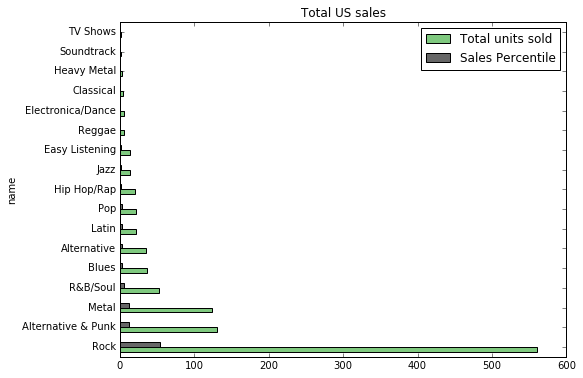

In [13]:
my_df.plot.barh(figsize=(8,6),title='Total US sales',colormap=plt.cm.Accent,xlim=(0,600))





it seems a little bit clearer now

#### Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. I have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [14]:
employee_query='''
SELECT e.first_name || " " || e.last_name 'Employee Name', e.title, e.hire_date, e.state, e.country, SUM(i.total) 'Total Sales'
FROM employee e LEFT JOIN customer c ON e.employee_id = c.support_rep_id 
LEFT JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1
ORDER BY 6 DESC
'''
run_query(employee_query)

,Employee Name,title,hire_date,state,country,Total Sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,AB,Canada,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,AB,Canada,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,AB,Canada,1393.92
3,Andrew Adams,General Manager,2016-08-14 00:00:00,AB,Canada,NaN
4,Laura Callahan,IT Staff,2017-03-04 00:00:00,AB,Canada,NaN
5,Michael Mitchell,IT Manager,2016-10-17 00:00:00,AB,Canada,NaN
6,Nancy Edwards,Sales Manager,2016-05-01 00:00:00,AB,Canada,NaN
7,Robert King,IT Staff,2017-01-02 00:00:00,AB,Canada,NaN


As we can see, Jane has the highest total sales. However, all three sales agents were hired months apart each other. So, is this really a good measure of how well they're doing?'

What if, we create a monthly sales average and compare that?

In [15]:
e_df=run_query(employee_query)

In [16]:
e_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
Employee Name    8 non-null object
title            8 non-null object
hire_date        8 non-null object
state            8 non-null object
country          8 non-null object
Total Sales      3 non-null float64
dtypes: float64(1), object(5)
memory usage: 464.0+ bytes


In [17]:
e_df['hire_date']=pd.to_datetime(e_df['hire_date'])

In [18]:
e_df['tenure']=(pd.to_datetime('today')-e_df['hire_date'])/30

In [19]:
e_df['tenure']=pd.to_numeric(e_df['tenure'].dt.days,downcast='float')

In [20]:
e_df['tenure']

0    17.0
1    16.0
2    10.0
3    25.0
4    18.0
5    22.0
6    28.0
7    20.0
Name: tenure, dtype: float32

We can now see the tenure of each employee. So, we can now do a sales average per month for each of them

In [21]:
e_df['avg_monthly_sales']=e_df['Total Sales']/e_df['tenure']

In [22]:
e_df['avg_monthly_sales']

0    101.853529
1     99.000000
2    139.392000
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
Name: avg_monthly_sales, dtype: float64

now that we have this, let's see the whole df again

In [23]:
e_df=e_df.sort_values(by='avg_monthly_sales',ascending=False)

In [24]:
e_df

,Employee Name,title,hire_date,state,country,Total Sales,tenure,avg_monthly_sales
2,Steve Johnson,Sales Support Agent,2017-10-17,AB,Canada,1393.92,10.0,139.392000
0,Jane Peacock,Sales Support Agent,2017-04-01,AB,Canada,1731.51,17.0,101.853529
1,Margaret Park,Sales Support Agent,2017-05-03,AB,Canada,1584.00,16.0,99.000000
3,Andrew Adams,General Manager,2016-08-14,AB,Canada,NaN,25.0,NaN
4,Laura Callahan,IT Staff,2017-03-04,AB,Canada,NaN,18.0,NaN
5,Michael Mitchell,IT Manager,2016-10-17,AB,Canada,NaN,22.0,NaN
6,Nancy Edwards,Sales Manager,2016-05-01,AB,Canada,NaN,28.0,NaN
7,Robert King,IT Staff,2017-01-02,AB,Canada,NaN,20.0,NaN


Now we see that the best performing sales agent is really Steve, who came third by our original analysis.

Let's see this in a plot

In [25]:
e_df.columns

Index(['Employee Name', 'title', 'hire_date', 'state', 'country',
       'Total Sales', 'tenure', 'avg_monthly_sales'],
      dtype='object')

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


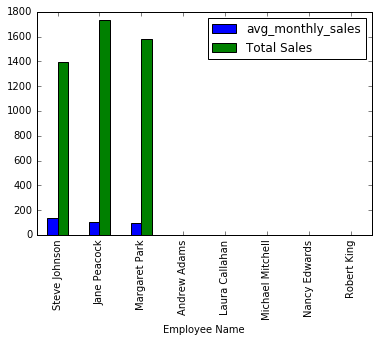

In [26]:
e_df.plot.bar(x='Employee Name',y=['avg_monthly_sales','Total Sales'])
plt.show()

### Steve Johnson has the best performing record of sales per month. Jane has the best record overall

## Analyzing sales by Country

In [27]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


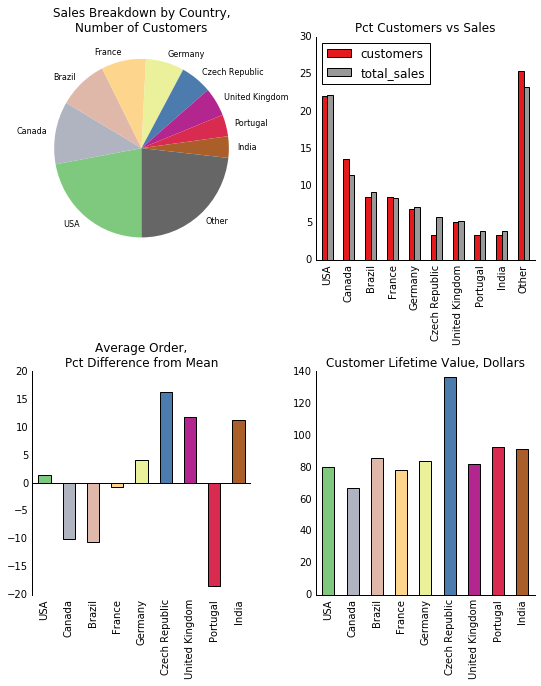

In [28]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

## Albums Vs Tracks

In [29]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.